In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append("../..")
import pandas as pd 
import geopandas as gpd
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
from src.bagData import BagData, create_tensorflow_iterator, create_bag_multiresolution_dictionary
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import gpflow 
from scipy.stats import sem
import json
import random 
import time 
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from src.svgp import MVBAgg
from src.util import optimize_adam, optimize_natgrad_adam, save_model, load_model
from src.plot_util import create_pixel_square,create_point
from sklearn.cluster import KMeans
seed = 0


In [3]:
lmbda0 = 0.5
lmbda1 = 1
lmbda2 = 1.5
lmbda3 = 2
def f_synthetic(x, lmbda):
    return x**2 * lmbda
    

In [4]:
np.random.seed(0)

In [5]:
# read in user-specified counties and states to study
dates = ['04-07']
counties_states = pd.read_csv("../../data/crops/counties-states.csv")
States = ["OHIO","ILLINOIS", "IOWA", "MICHIGAN", "MISSOURI", "NORTH DAKOTA", "SOUTH DAKOTA"]
col_latlon = ["longitude", "latitude"]
col_modis = [f"EVI_{date}" for date in dates]
col_gridmet = [f"pr_{date}" for date in dates] + [f"tmmx_{date}" for date in dates]

# read in latlon
df_latlon = pd.read_csv("../../data/crops/processed_covariates/latlon-500_data_all.csv")
df_latlon["key"] = df_latlon["County"] + "-" + df_latlon["State"]
df_latlon = df_latlon[df_latlon["key"].isin(counties_states["key"])]
df_latlon = df_latlon.drop_duplicates(["County", "State", "longitude", "latitude"])

# read in and take subset of features data
df_modis = pd.read_csv("../../data/crops/processed_covariates/MOD13Q1-1000-all_data.csv")
df_modis = df_modis[df_modis["year"]==2015]
df_modis["key"] = df_modis["County"] + "-" + df_modis["State"]
df_modis = df_modis[df_modis["key"].isin(counties_states["key"])]
features = ["year", "key", "County", "State", "longitude", "latitude"] + [f"EVI_{date}" for date in dates]
df_modis = df_modis[features]
df_modis = df_modis.dropna()
df_modis = df_modis.drop_duplicates(["County", "State", "longitude", "latitude", "year"])


# read in and take subset of features data
df_gridmet = pd.read_csv("../../data/crops/processed_covariates/GRIDMET-all_data.csv")
df_gridmet = df_gridmet[df_gridmet["year"]==2015]
df_gridmet["key"] = df_gridmet["County"] + "-" + df_gridmet["State"]
df_gridmet = df_gridmet[df_gridmet["key"].isin(counties_states["key"])]
features = ["key", "year", "County", "State", "longitude", "latitude"] + col_gridmet
df_gridmet = df_gridmet[features]
df_gridmet = df_gridmet.drop_duplicates(["County", "State", "longitude", "latitude", "year"])

In [9]:
len(df_modis.key.unique())

384

In [12]:
df_modis.groupby("key").count().max()

year         5950
County       5950
State        5950
longitude    5950
latitude     5950
EVI_04-07    5950
dtype: int64

In [21]:
scaler_latlon = StandardScaler().fit(df_latlon[["longitude", "latitude"]].values)
scaler_modis = StandardScaler().fit(df_modis[["EVI_04-07"]].values)
scaler_pr = StandardScaler().fit(df_gridmet[["pr_04-07"]].values)
scaler_tmmx = StandardScaler().fit(df_gridmet[["tmmx_04-07"]].values)

df_latlon[["longitude", "latitude"]] = scaler_latlon.transform(df_latlon[["longitude", "latitude"]].values)
df_modis["EVI_04-07"] = scaler_modis.transform(df_modis[["EVI_04-07"]].values)
df_gridmet["pr_04-07"] = scaler_pr.transform(df_gridmet[["pr_04-07"]].values)
df_gridmet["tmmx_04-07"] = scaler_tmmx.transform(df_gridmet[["tmmx_04-07"]].values)

df_latlon["f0_lon"] = df_latlon[["longitude"]].apply(lambda x: f_synthetic(x, lmbda0))
df_latlon["f0_lat"] = df_latlon[["latitude"]].apply(lambda x: f_synthetic(x, lmbda0))
df_modis["f1"] = df_modis["EVI_04-07"].apply(lambda x: f_synthetic(x, lmbda1))
df_gridmet["f2"] = df_gridmet["pr_04-07"].apply(lambda x: f_synthetic(x, lmbda2))
df_gridmet["f3"] = df_gridmet["tmmx_04-07"].apply(lambda x: f_synthetic(x, lmbda3))

In [22]:
df_latlon_grouped = df_latlon[["key", "f0_lon", "f0_lat"]].groupby(["key"]).mean().reset_index()
df_modis_grouped = df_modis[["key", "f1"]].groupby(["key"]).mean().reset_index()
df_gridmet_grouped = df_gridmet[["key", "f2", "f3"]].groupby(["key"]).mean().reset_index()

In [23]:
df_response = df_modis_grouped[["key"]]
df_response["y"] = df_latlon_grouped["f0_lon"] + df_latlon_grouped["f0_lat"] + df_modis_grouped["f1"] + df_gridmet_grouped["f2"] + df_gridmet_grouped["f3"]
df_response["y"] = df_response["y"] + np.random.normal(scale=0.5,size=(df_response.shape[0]))

In [24]:
county_shapes = gpd.read_file("../../data/crops/yield_data_final.geojson")
county_shapes["key"] = county_shapes["County"] + "-" + county_shapes["State"]

<AxesSubplot:>

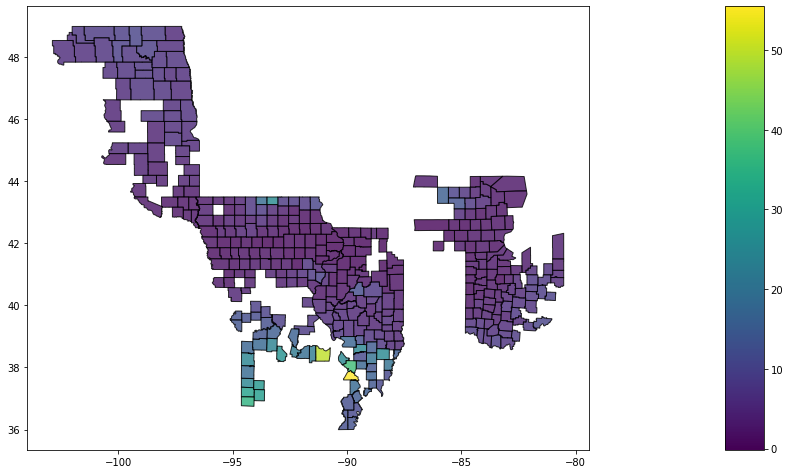

In [25]:
gdf_response = gpd.GeoDataFrame(df_response.merge(county_shapes))
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
gdf_response.plot(column="y", edgecolor='black', alpha=0.8, legend=True, ax=ax, cax=cax)

In [26]:
df_response.to_csv("../../data/synthetic/synthetic_yields.csv", index=False)
gdf_response.to_file("../../data/synthetic/synthetic_yields.geojson", index=False)